In [1]:
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
import os
import pandas as pd
import time

## Data generation

In [2]:
def get_ER_adj_matrix(N, p):
    m = np.zeros((N,N))
    edges = np.random.binomial(1, p, N*(N-1)//2)
    m[np.tril_indices(N, -1)]=edges
    m = m + m.T
    return m

In [3]:
def get_generalied_ER_adj_matrix(N_communities, community_size, p_within_community, p_between_community):
    
    full_m = np.zeros((N_communities*community_size, N_communities*community_size))
    for com_number in range(N_communities):
        m = get_ER_adj_matrix(community_size, p_within_community)
        full_m[com_number*community_size:(com_number+1)*community_size, com_number*community_size:(com_number+1)*community_size] = m

    N = N_communities * community_size

    between_com_edges_number = N*(N-1)//2 - N_communities * (community_size*(community_size-1)//2)
    between_com_edges = np.random.binomial(1, p_between_community, between_com_edges_number)
    between_com_lower_trian = np.zeros((N_communities*community_size, N_communities*community_size))

    already_taken = 0
    for com_number in range(1, N_communities):
        number_to_take = community_size*com_number*community_size

        between_com_lower_trian[com_number*community_size:(com_number+1)*community_size, 0:com_number*community_size] = \
            between_com_edges[already_taken : already_taken + number_to_take].reshape(community_size, -1)

        already_taken += number_to_take

    full_m = full_m + between_com_lower_trian + between_com_lower_trian.T
    return full_m

In [4]:
N_communities = 3
community_size = 20
p_within_community = 0.8
p_between_community = 0.01

m = get_generalied_ER_adj_matrix(N_communities, community_size, p_within_community, p_between_community)
generalized_ER = nx.from_numpy_array(m)

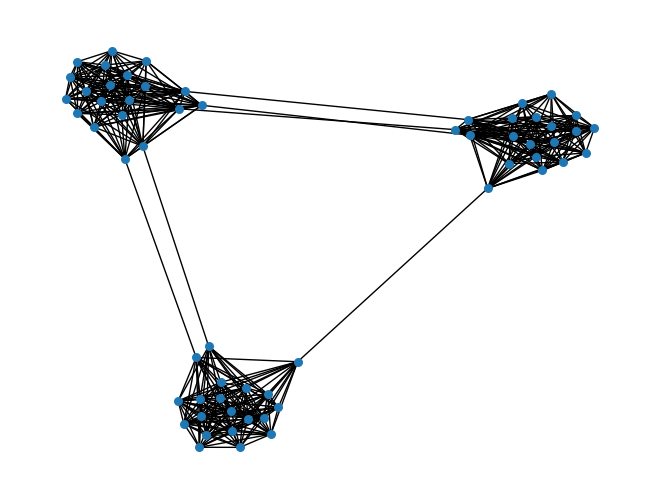

In [5]:
nx.draw(generalized_ER, node_size=30)

## Spectral community detection

In [6]:
def get_unnorm_laplacian_matrix(adj_matrix):
    degs = np.sum(adj_matrix, axis = 1) 
    D = np.diag(degs)
    L = D - adj_matrix
    return L

In [7]:
def detect_idx_of_communities(evals):
    '''
    detects number of communitites and return their indexes
    '''
    sorted_evals = np.sort(evals)
    distances = sorted_evals[1:] - sorted_evals[:-1]
    distances_argmax = np.argmax(distances)
    last_small_eigval_idx = distances_argmax
    threshold_eigval = sorted_evals[last_small_eigval_idx]
    smalles_eigvals_idxs = np.where(evals<=threshold_eigval)[0]
    if len(smalles_eigvals_idxs) == 1: # assume more than 1 comunities in data
        distaces_no_argmax = np.delete(distances, distances_argmax) # take second max dist
        last_small_eigval_idx = np.argmax(distaces_no_argmax)+1
        threshold_eigval = sorted_evals[last_small_eigval_idx]
        smalles_eigvals_idxs = np.where(evals<=threshold_eigval)[0]

    return smalles_eigvals_idxs

In [8]:
def get_n_lowest_eig(L, n = None):
    L_evals, L_evec = np.linalg.eig(L)
    if n is None:
        zero_evals_idx = detect_idx_of_communities(L_evals)
    else:
        zero_evals_idx = np.argpartition(L_evals, n)[:n]
    lowest_evals = L_evals[zero_evals_idx]
    lowest_evec = L_evec[:,zero_evals_idx]
    return lowest_evals, lowest_evec

In [9]:
def cluster_vertices(vertex_data, number_of_cluster):
    kmeans = KMeans(n_clusters=number_of_cluster)
    return kmeans.fit_predict(vertex_data)

In [10]:
def get_null_model_adj(vert_number, edges_num):
    ''' As far as I understand the null model is the most random one so I assume it is mean number of edges per vertex'''
    val = vert_number/edges_num
    return np.ones((vert_number,vert_number)) * val
    

In [11]:
def calculate_modularity(adj_matrix,vertices_clusters,edges_num):
    modularity_score = 0
    null_model_matrix = get_null_model_adj(len(vertices_clusters),edges_num)
    for i in range(len(vertices_clusters)):
        for j in range(i,len(vertices_clusters)):
                modularity_score+=(vertices_clusters[i]==vertices_clusters[j])\
                    *(adj_matrix[i,j]-null_model_matrix[i,j])
    modularity_score/=(2*edges_num)
    return modularity_score


In [12]:
def determine_best_cluster_vertices(L,G):
        L_evals, L_evec = np.linalg.eig(L)
        # estimate
        n =  len(detect_idx_of_communities(L_evals))
        # adj matrix
        adj_matrix = nx.adjacency_matrix(G)
        # tuple to hold the best solution
        best_val, best_sol = -np.inf,None
        for number_of_comm in range(max(1,n-5),n+5):
                vertex_data = get_n_lowest_eig(L, n=number_of_comm)[1]
                number_of_clusters = np.shape(vertex_data)[1]
                vertices_clusters = cluster_vertices(vertex_data, number_of_cluster=number_of_clusters)
                modularity = calculate_modularity(adj_matrix,vertices_clusters,len(G.edges))
                if modularity > best_val:
                        best_val = modularity
                        best_sol = vertices_clusters
        return best_sol
            


In [13]:
def detect_communities(G: nx.Graph, number_of_comm = None, plot = False, modularity_score = False):
    m =  np.asarray(nx.to_numpy_matrix(G))
    L = get_unnorm_laplacian_matrix(m)
    if number_of_comm is None and modularity_score:
        vertices_clusters = determine_best_cluster_vertices(L,G)   
    else:
        vertex_data = get_n_lowest_eig(L, n=number_of_comm)[1]
        number_of_clusters = np.shape(vertex_data)[1]
        vertices_clusters = cluster_vertices(vertex_data, number_of_cluster=number_of_clusters)
    if plot:
        nx.draw(G, node_size=30, node_color=vertices_clusters)
    if modularity_score:
        modularity = calculate_modularity(m,vertices_clusters,len(G.edges))
        print(f"Modularity score: {modularity}")
    return vertices_clusters


# Modularity calculations

## Visual example

Modularity score: 0.39965716857633726


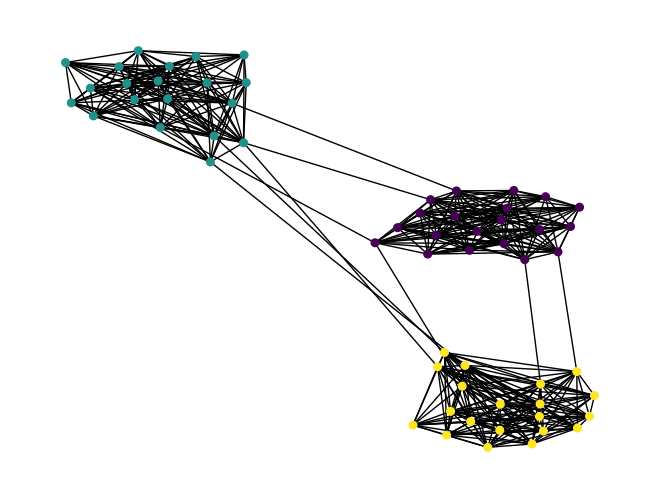

In [14]:
N_communities = 3
community_size = 20
p_within_community = 0.8
p_between_community = 0.01

m = get_generalied_ER_adj_matrix(N_communities, community_size, p_within_community, p_between_community)
generalized_ER = nx.from_numpy_array(m)
ars = detect_communities(generalized_ER, number_of_comm=N_communities, plot=True,modularity_score=True)

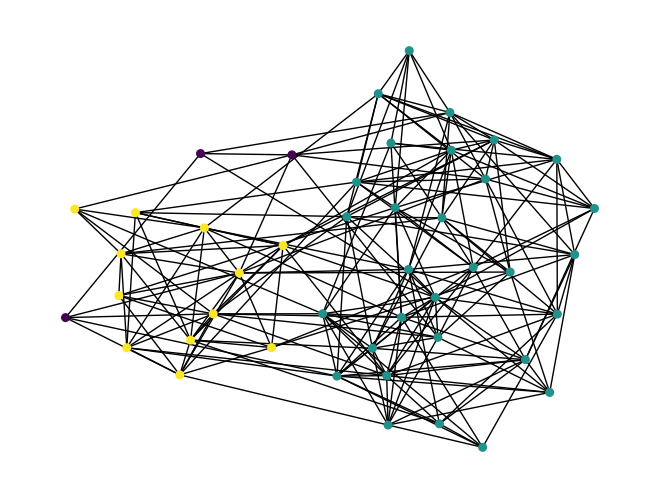

In [15]:
N_communities = 3
community_size = 15
p_within_community = 0.5
p_between_community = 0.1

m = get_generalied_ER_adj_matrix(N_communities, community_size, p_within_community, p_between_community)
generalized_ER = nx.from_numpy_array(m)
ars = detect_communities(generalized_ER, number_of_comm=N_communities, plot=True)

## Tests for known number of clusters 

#### different number of communities

In [16]:
N_communities_seq = [2, 3, 4, 5, 6, 10, 20, 50, 100, 200]
community_size = 20
p_within_community = 0.8
p_between_community = 0.01
Graphs = [nx.from_numpy_array(get_generalied_ER_adj_matrix(N_communities, community_size, p_within_community, p_between_community)) for N_communities in N_communities_seq]
Graph_comm_gts = [np.array([[i]*community_size for i in range(N_communities)]).flatten() for N_communities in N_communities_seq]

In [17]:
detected_comms = [detect_communities(G, number_of_comm=N_communities) for (G, N_communities) in zip(Graphs, N_communities_seq)]
ars = [adjusted_rand_score(Graph_comm_gt, detected_comm) for (Graph_comm_gt, detected_comm) in zip(Graph_comm_gts, detected_comms)]

In [18]:
ars

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9877793215859161, 0.430194810735148]

### different sizes of communities 

In [19]:
N_communities = 5
community_size_seq = [2, 5, 10, 50, 100, 150]
p_within_community = 0.8
p_between_community = 0.01
Graphs = [nx.from_numpy_array(get_generalied_ER_adj_matrix(N_communities, community_size, p_within_community, p_between_community)) for community_size in community_size_seq]
Graph_comm_gts = [np.array([[i]*community_size for i in range(N_communities)]).flatten() for community_size in community_size_seq]

In [20]:
detected_comms = [detect_communities(G, number_of_comm=N_communities) for G in Graphs]
ars = [adjusted_rand_score(Graph_comm_gt, detected_comm) for (Graph_comm_gt, detected_comm) in zip(Graph_comm_gts, detected_comms)]

In [21]:
ars

[0.37623762376237624, 0.702054794520548, 1.0, 1.0, 1.0, 1.0]

### different p_within

In [22]:
N_communities = 5
community_size = 20
p_within_community_seq = [0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 1.0]
p_between_community = 0.01
Graphs = [nx.from_numpy_array(get_generalied_ER_adj_matrix(N_communities, community_size, p_within_community, p_between_community)) for p_within_community in p_within_community_seq]
Graph_comm_gts = [np.array([[i]*community_size for i in range(N_communities)]).flatten() for _ in range(len(p_within_community_seq))]

In [23]:
detected_comms = [detect_communities(G, number_of_comm=N_communities) for G in Graphs]
ars = [adjusted_rand_score(Graph_comm_gt, detected_comm) for (Graph_comm_gt, detected_comm) in zip(Graph_comm_gts, detected_comms)]

In [24]:
ars

[0.0009656977308960418,
 0.7581929044615088,
 0.9746088740702744,
 1.0,
 1.0,
 1.0,
 1.0]

#### different p_between

In [25]:
N_communities = 5
community_size = 20
p_within_community = 0.8
p_between_community_seq = [0.0001, 0.001, 0.01, 0.03, 0.05, 0.1, 0.2, 0.4, 0.5, 0.7, 0.8]
Graphs = [nx.from_numpy_array(get_generalied_ER_adj_matrix(N_communities, community_size, p_within_community, p_between_community)) for p_between_community in p_between_community_seq]
Graph_comm_gts = [np.array([[i]*community_size for i in range(N_communities)]).flatten() for _ in range(len(p_between_community_seq))]

In [26]:
detected_comms = [detect_communities(G, number_of_comm=N_communities) for G in Graphs]
ars = [adjusted_rand_score(Graph_comm_gt, detected_comm) for (Graph_comm_gt, detected_comm) in zip(Graph_comm_gts, detected_comms)]

In [27]:
ars

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.1683213685657553,
 0.10854923410383603,
 -0.001095297991718134,
 -0.00047717241261780195]

### Tests for not known number of communities

In [28]:
N_communities_seq = [2, 3, 4, 5, 6, 10, 20, 50, 100]
community_size = 20
p_within_community = 0.8
p_between_community = 0.01
Graphs = [nx.from_numpy_array(get_generalied_ER_adj_matrix(N_communities, community_size, p_within_community, p_between_community)) for N_communities in N_communities_seq]
Graph_comm_gts = [np.array([[i]*community_size for i in range(N_communities)]).flatten() for N_communities in N_communities_seq]

In [29]:
detected_comms = [detect_communities(G, number_of_comm=None) for G in Graphs]
ars = [adjusted_rand_score(Graph_comm_gt, detected_comm) for (Graph_comm_gt, detected_comm) in zip(Graph_comm_gts, detected_comms)]

In [30]:
ars

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -4.0011746606451095e-06]

### Heuristic detection of communities - justification

In [31]:
N_communities_seq = [2, 3, 4, 5, 6, 10, 20, 50, 100, 200]
community_size = 20
p_within_community = 0.8
p_between_community = 0.01
Graphs = [nx.from_numpy_array(get_generalied_ER_adj_matrix(N_communities, community_size, p_within_community, p_between_community)) for N_communities in N_communities_seq]

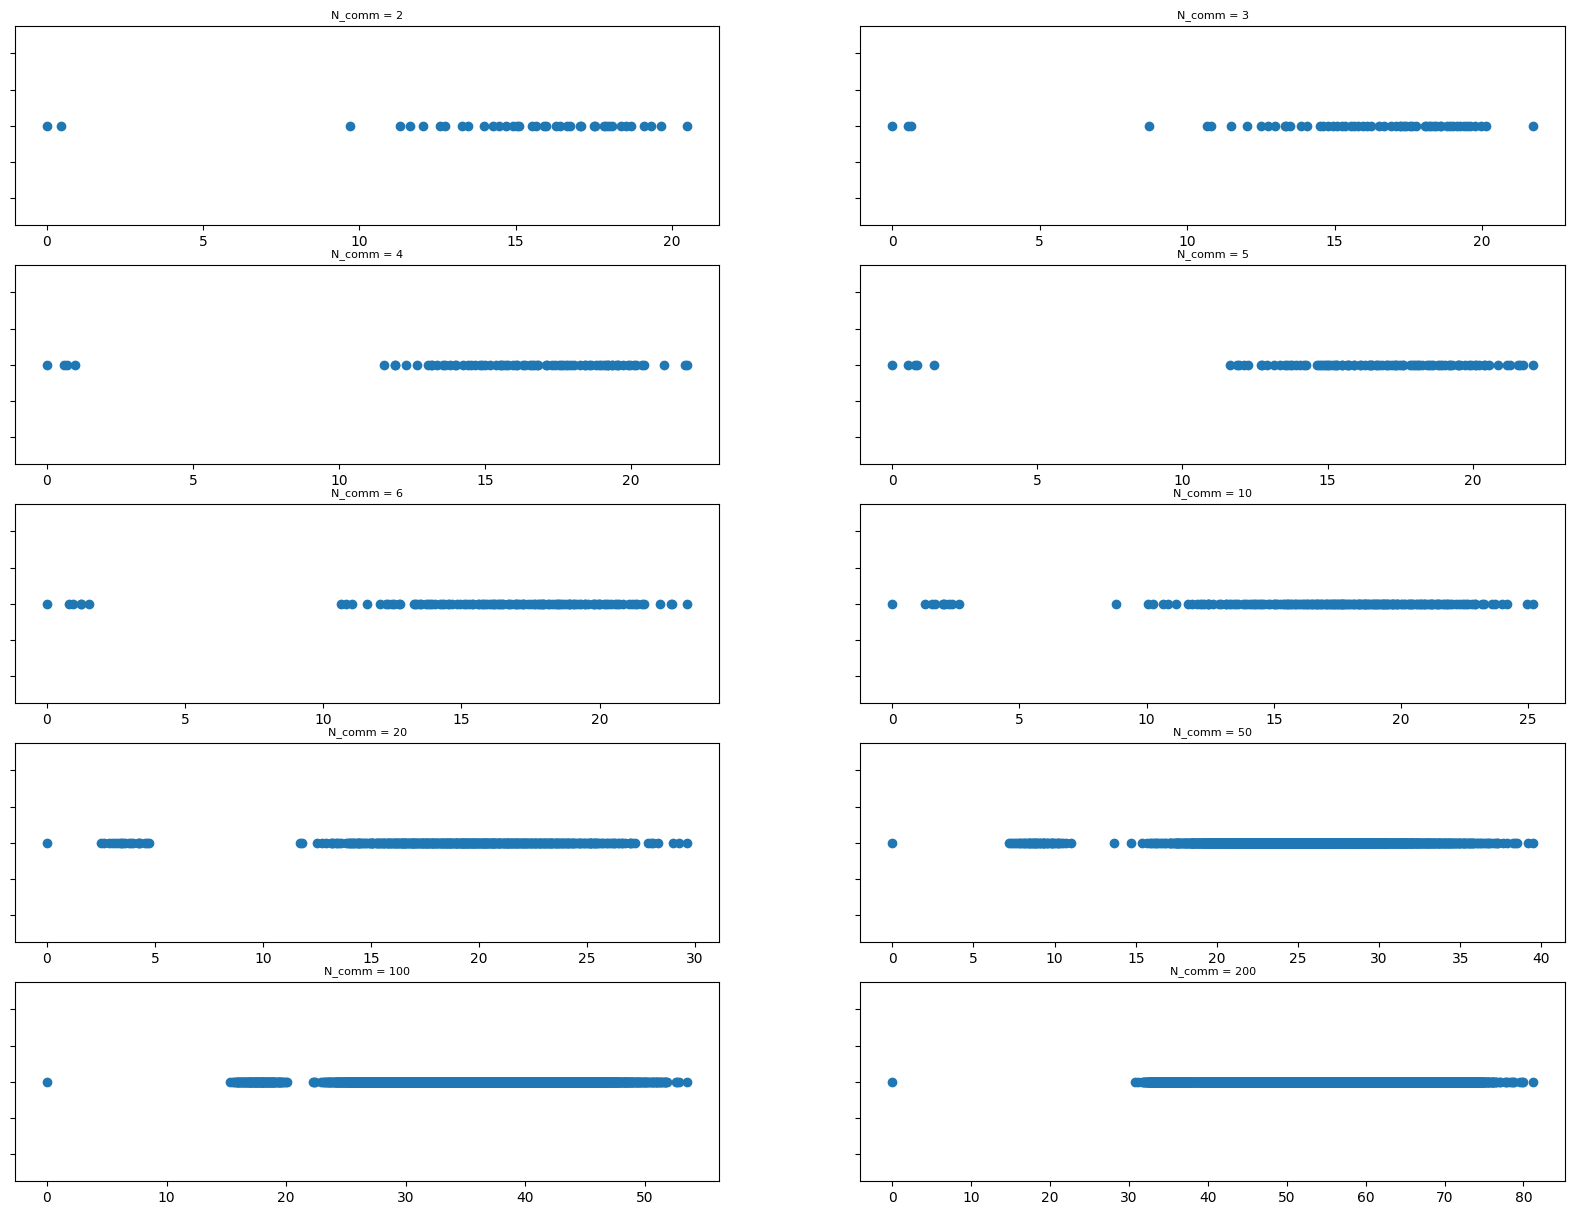

In [32]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, 2, figsize = (20, 15))


for i in range(5):
    for j in range(2):
        axes[i,j].set_yticklabels([])
        axes[i,j].set_title(f'N_comm = {N_communities_seq[i*2+j]}', fontsize=8)

        G = Graphs[i*2+j]
        m =  np.asarray(nx.to_numpy_matrix(G))
        L = get_unnorm_laplacian_matrix(m)
        evals = np.linalg.eig(L)[0]
        axes[i,j].scatter(evals, np.zeros_like(evals), marker='o')

# Competition

In [33]:
data_folder = 'competition'
results_folder = 'gozdera_hadasz'

In [34]:
file_with_comunity_number = dict(zip(os.listdir(data_folder), [2,None,7,None,12,None]))
trials = 10

D1-K=2.csv
Modularity score: -0.5624589086127518
number of detected communities 2


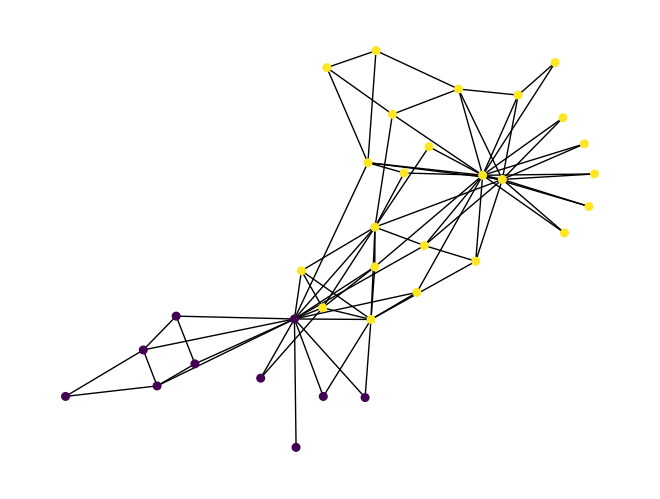

D1-UNC.csv


C:\Users\gosia\AppData\Local\Temp\ipykernel_80388\1519650738.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G)


Modularity score: 0.16415522248915423
number of detected communities 25


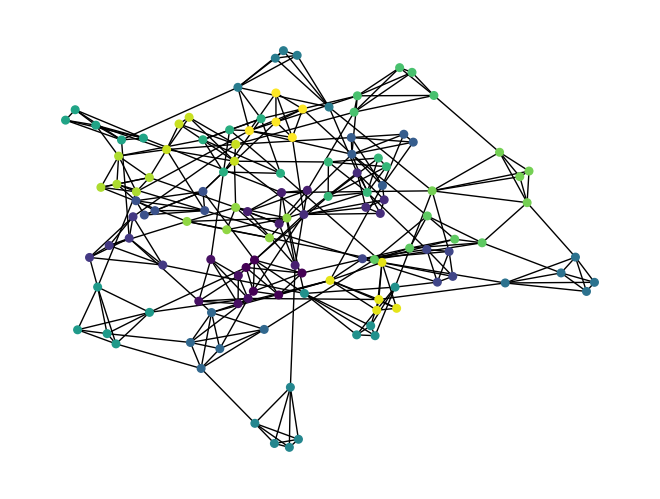

D2-K=7.csv
Modularity score: -0.5838574423480093
number of detected communities 7


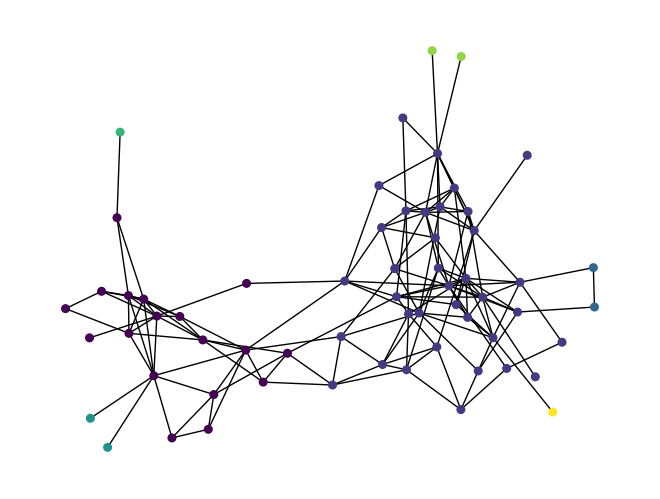

D2-UNC.csv


C:\Users\gosia\AppData\Local\Temp\ipykernel_80388\1519650738.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G)


Modularity score: 0.2890165233137148
number of detected communities 15


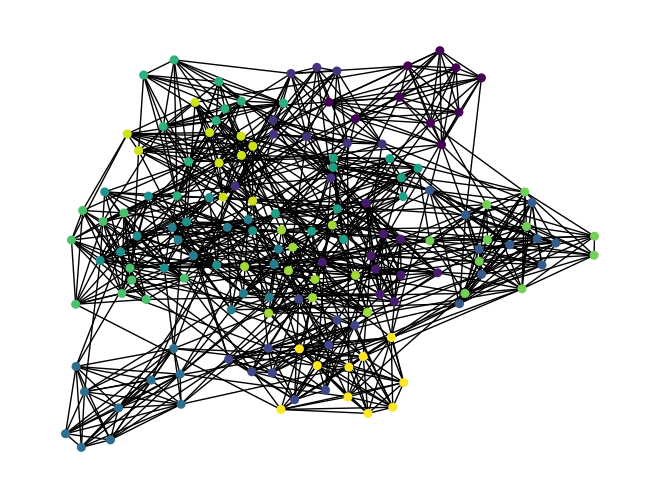

D3-K=12.csv
Modularity score: 0.2464798852486499
number of detected communities 12


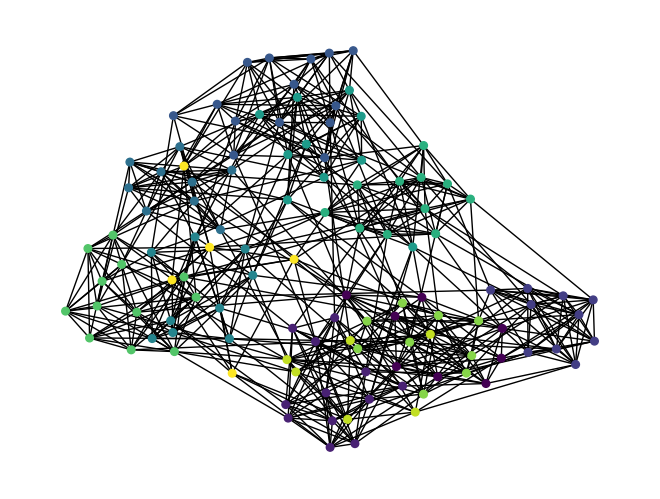

D3-UNC.csv


C:\Users\gosia\AppData\Local\Temp\ipykernel_80388\1519650738.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G)


Modularity score: 0.2624626321315187
number of detected communities 9


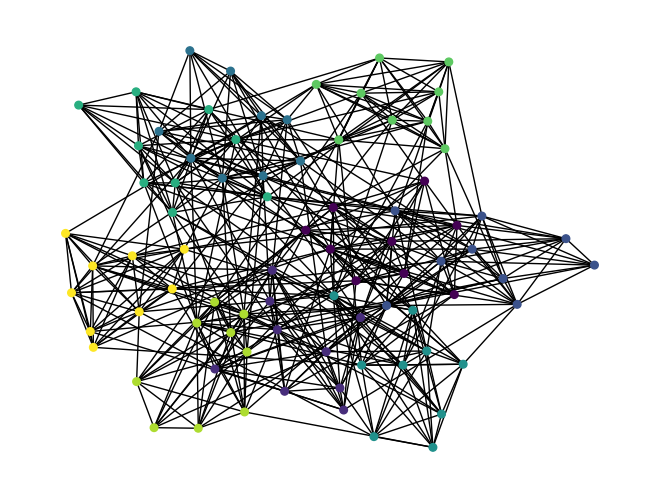

In [35]:
time_elapsed = {}
for file, n_communities in file_with_comunity_number.items():
    print(file)
    # measuring time
    start = time.time()
    # reading data
    edges = pd.read_csv(os.path.join(data_folder,file), header=None)
    graph = nx.from_pandas_adjacency(edges)
    for _ in range(trials):
        ars = detect_communities(graph, number_of_comm=n_communities, plot=False)
    end = time.time()
    # saving elapsed time
    time_elapsed[file] =(end-start)/trials
    ars = detect_communities(graph, number_of_comm=n_communities, plot=True,modularity_score=True)
    ars +=1 # number of group starts from one
    print(f"number of detected communities {len(np.unique(ars))}")
    plt.show()
    pd.DataFrame(data = ars, index = list(range(1,len(ars)+1))).to_csv(os.path.join(results_folder,file),header=None)

## creating the describtion file

In [36]:
with open(os.path.join(results_folder,'description.txt'),'w') as f:
    f.write("Michal Gozdera, Malgorzata Hadasz \n")
    f.write("https://github.com/hadaszm/SNARS \n")
    for file, t in time_elapsed.items():
        f.write("{}, {}\n".format(file, t))
